Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Read the data

### Importing all the important libraries

In [45]:
import pathlib
import tensorflow as tf
import glob
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [47]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
basepath ='C:\\Learnings\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train= pathlib.Path(basepath + '/Train')
data_dir_test=pathlib.Path(basepath + '/Test')
#data_dir_train = pathlib.Path("path_to_train_directory")
#data_dir_test = pathlib.Path('path_to_test_directory')

In [48]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [49]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [50]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  subset="training",
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=False,
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [51]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [52]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
####  code to visualize one instance of all the nine classes present in the dataset

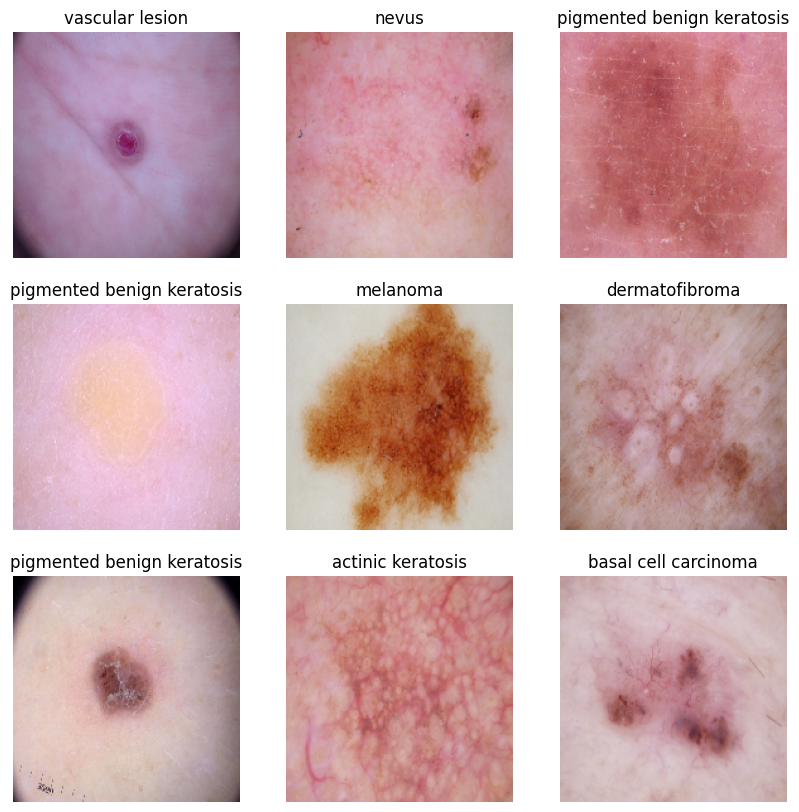

In [53]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [55]:
### Your code goes here
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

(32, 180, 180, 3)
(32,)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [56]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [58]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 37ms/step - loss: 1.8742 - accuracy: 0.3170 - val_loss: 1.6322 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5637 - accuracy: 0.4475 - val_loss: 1.4615 - val_accuracy: 0.5078
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4193 - accuracy: 0.5028 - val_loss: 1.3533 - val_accuracy: 0.5660
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3108 - accuracy: 0.5363 - val_loss: 1.3499 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1987 - accuracy: 0.5809 - val_loss: 1.3616 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0857 - accuracy: 0.6161 - val_loss: 1.2992 - val_accuracy: 0.5638
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0065 - accuracy: 0.6300 - val_loss: 1.4165 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing training results

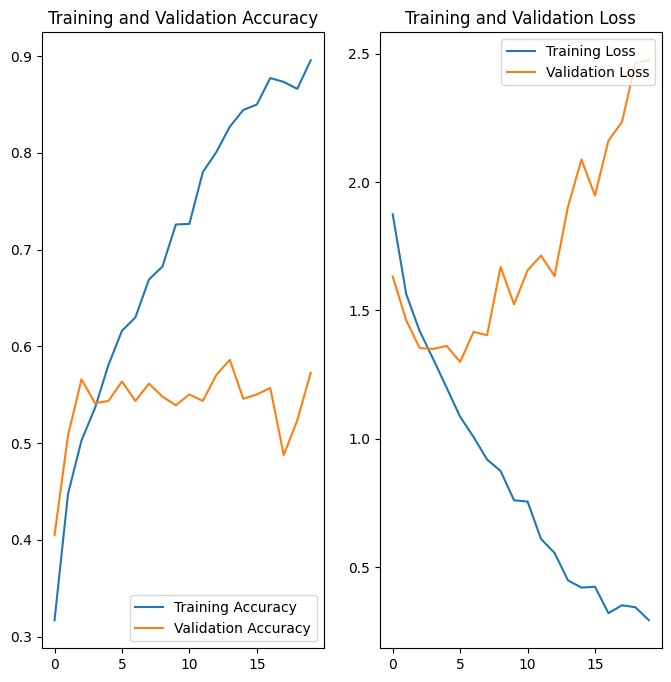

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
Model is clearly overfitting as there is a big difference in accuracy between training and validation data

In [60]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, 
                                                              img_width,
                                                              3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
])


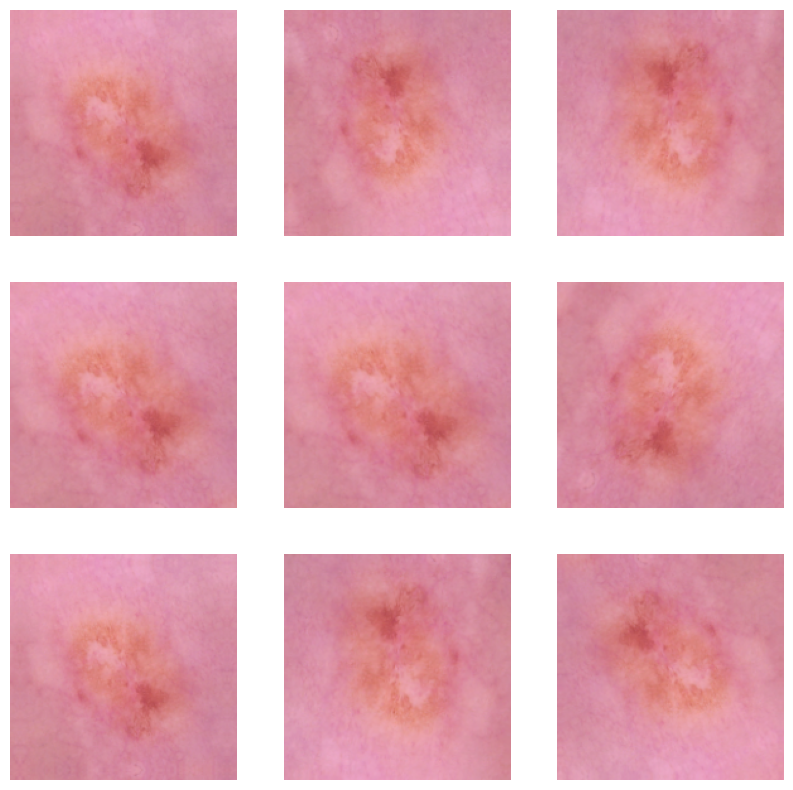

In [61]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [62]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
## This is the technique to reduce overfitting is to introduce dropout regularization to the network.
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

### Compiling the model

In [63]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [64]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9644 - accuracy: 0.2835 - val_loss: 1.6928 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6059 - accuracy: 0.4146 - val_loss: 1.8013 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4841 - accuracy: 0.4771 - val_loss: 1.6685 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4815 - accuracy: 0.4676 - val_loss: 1.4211 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4093 - accuracy: 0.5156 - val_loss: 1.3823 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3610 - accuracy: 0.5195 - val_loss: 1.4299 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.2774 - accuracy: 0.5335 - val_loss: 1.4038 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

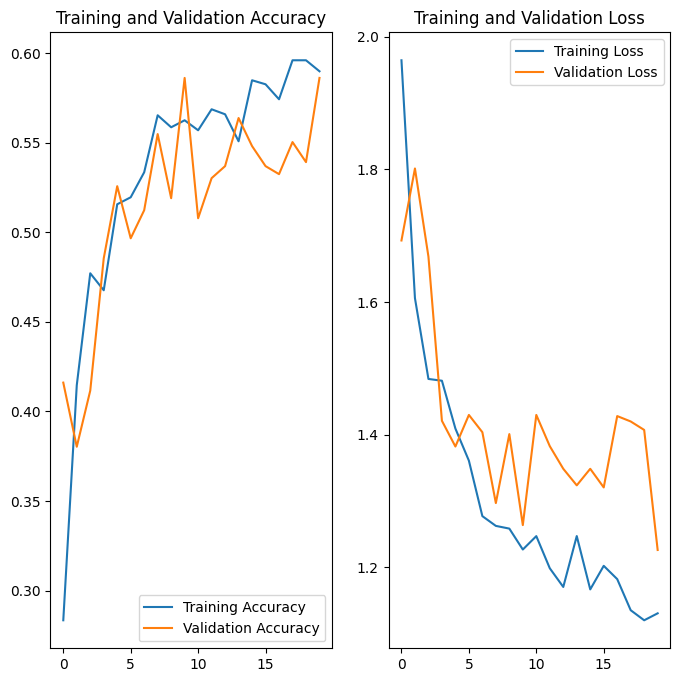

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model 2 : After data augmentation and adding dropping layer,overfitting has been reduced.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [66]:
#Checking distribution of calsses in the data
folders = ([name for name in os.listdir(data_dir_train)
            if os.path.isdir(os.path.join(data_dir_train, name))]) 
for folder in folders:
    contents = os.listdir(os.path.join(data_dir_train,folder)) 
    print(folder+":"+str(len(contents)))

actinic keratosis:114
basal cell carcinoma:376
dermatofibroma:95
melanoma:438
nevus:357
pigmented benign keratosis:462
seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
# seborrheic keratosis:78
#### - Which classes dominate the data in terms proportionate number of samples?
#pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [67]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [68]:
path_to_training_dataset=data_dir_train
print(path_to_training_dataset)
path_to_training_dataset= pathlib.Path(basepath + '/Train')
csp = str(path_to_training_dataset)
import Augmentor
for i in class_names:
    pipeline = Augmentor.Pipeline(csp + '\\'+i)
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipeline.zoom(probability=0.5, min_factor=1.1, max_factor=1.3)
    pipeline.random_distortion(probability=0.8, grid_width=4, grid_height=4, magnitude=1)
    pipeline.greyscale(1.0)
    pipeline.invert(1.0)
    pipeline.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train
Initialised with 114 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x260ADDBA040>: 100%|█| 500/500 [00:02<00:00, 204.67 Samples/s


Initialised with 376 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x260ADE14B80>: 100%|█| 500/500 [00:02<00:00, 205.39 Samples/s


Initialised with 95 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x260B103CF40>: 100%|█| 500/500 [00:02<00:00, 192.15 Samples/s


Initialised with 438 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=L size=966x638 at 0x260AE7D52B0>: 100%|█| 500/500 [00:15<00:00, 32.50 Samples/s]


Initialised with 357 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=L size=824x719 at 0x260ADDE8460>: 100%|█| 500/500 [00:15<00:00, 31.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x260B1069370>: 100%|█| 500/500 [00:02<00:00, 189.93 Samples/s


Initialised with 77 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=L size=1024x768 at 0x260AE7DE4C0>: 100%|█| 500/500 [00:06<00:00, 72.90 Samples/s


Initialised with 181 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x260AE71CE20>: 100%|█| 500/500 [00:02<00:00, 175.92 Samples/s


Initialised with 139 image(s) found.
Output directory set to C:\Learnings\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=L size=600x450 at 0x260AE05F970>: 100%|█| 500/500 [00:02<00:00, 183.84 Samples/s


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [69]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [70]:
import glob

In [71]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list


['C:\\Learnings\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_16f376cd-3286-4b2a-804c-33dcb96b252f.jpg',
 'C:\\Learnings\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_29e976c8-d49b-4c0e-a541-6810fc989ff4.jpg',
 'C:\\Learnings\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3b4b5bda-3999-4a6a-8370-49cbd42c4003.jpg',
 'C:\\Learnings\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_018edc01-af92-4da5-aba0-ca76b44f889a.jpg',
 'C:\\Learnings\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\ac

In [72]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [73]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [74]:
dataframe_dict = dict(zip(path_list, dataframe_dict_new))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\Vtiwary\AppData\Local\Temp\ipykernel_17136\1195802245.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [75]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\Vtiwary\AppData\Local\Temp\ipykernel_17136\217693315.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [76]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [77]:
batch_size = 32
img_height = 180
img_width = 180

In [78]:
data_dir_train= os.path.join(data_dir_train)
data_dir_train

'C:\\Learnings\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train'

#### **Todo:** Create a training dataset

In [79]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [80]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [81]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [82]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

(32, 180, 180, 3)
(32,)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [83]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [84]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 7s 39ms/step - loss: 2.1593 - accuracy: 0.1654 - val_loss: 2.0916 - val_accuracy: 0.2012
Epoch 2/50
169/169 [==============================] - 5s 30ms/step - loss: 2.0384 - accuracy: 0.2237 - val_loss: 2.0182 - val_accuracy: 0.2480
Epoch 3/50
169/169 [==============================] - 5s 30ms/step - loss: 1.9349 - accuracy: 0.2860 - val_loss: 1.9138 - val_accuracy: 0.3111
Epoch 4/50
169/169 [==============================] - 5s 30ms/step - loss: 1.8712 - accuracy: 0.3116 - val_loss: 1.8216 - val_accuracy: 0.3430
Epoch 5/50
169/169 [==============================] - 5s 30ms/step - loss: 1.8131 - accuracy: 0.3288 - val_loss: 1.8460 - val_accuracy: 0.3281
Epoch 6/50
169/169 [==============================] - 5s 30ms/step - loss: 1.7536 - accuracy: 0.3540 - val_loss: 1.7427 - val_accuracy: 0.3860
Epoch 7/50
169/169 [==============================] - 5s 30ms/step - loss: 1.7123 - accuracy: 0.3730 - val_loss: 1.7664 - val_accuracy: 0.3742

#### **Todo:**  Visualize the model results

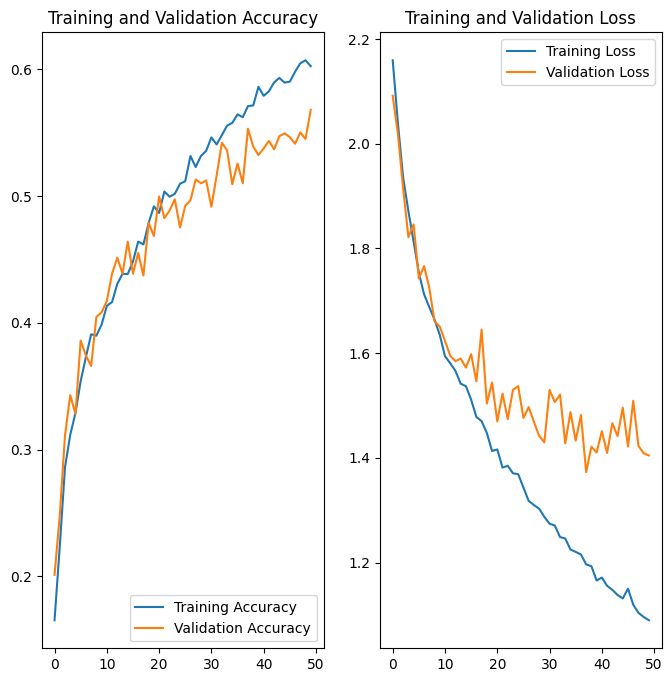

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [86]:
##### This removes overfitting problem. Certainly class rebalance helped here.